<a href="https://colab.research.google.com/github/mohitraosatya/qci-bio-optimizer/blob/main/Quantum_Circuits_Inc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bio-Inspired Quantum Circuit Optimizer for QCI’s Dual-Rail Architecture

**Author:** Satya Mohit Rao Kamkanampati

**Email:** saka4331@colorado.edu

This notebook implements a nature-inspired Genetic Algorithm to optimize quantum circuits designed to simulate the dual-rail qubit architecture, similar to Quantum Circuits Inc. (QCI). The goal is to evolve gate parameters that preserve valid dual-rail encodings and improve circuit fidelity under error-prone conditions.

By incorporating logical qubits using pairs of physical qubits and validating output states, this optimizer mimics QCI’s built-in error detection approach. The framework is modular, scalable, and designed to align with fault-tolerant quantum computing architectures.


In [1]:
!pip install numpy qiskit
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 44.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [3]:
def create_dual_rail_circuit(params):
    """
    Simulate dual-rail qubit architecture.
    Logical qubit 1: q0-q1 (0=|10⟩, 1=|01⟩)
    Logical qubit 2: q2-q3
    """
    qc = QuantumCircuit(4, 4)

    # Encode logical |0⟩ as |10> and logical |1⟩ as |01>
    qc.x(0)  # Start in |10> for logical 0
    qc.x(2)  # Start in |10> for logical 0

    # Apply parametrized noise-aware logic
    qc.rx(params[0], 0)
    qc.rx(params[1], 1)
    qc.ry(params[2], 2)
    qc.ry(params[3], 3)

    # Entangle logical qubits (simulate CX on logical qubit)
    qc.cx(1, 3)

    # Measure all for error detection (simplified)
    qc.measure(range(4), range(4))

    return qc


In [4]:
def fitness_function(params):
    circuit = create_dual_rail_circuit(params)
    simulator = AerSimulator()
    transpiled = transpile(circuit, simulator)
    result = simulator.run(transpiled, shots=1024).result()
    counts = result.get_counts()

    valid = 0
    total = sum(counts.values())

    for outcome, count in counts.items():
        bits = list(outcome[::-1])  # reverse due to qiskit's ordering
        lq1 = bits[0:2]
        lq2 = bits[2:4]
        if lq1.count("1") == 1 and lq2.count("1") == 1:
            valid += count

    return valid / total


In [5]:
def initialize_population(size):
    return np.random.uniform(0, 2*np.pi, (size, 4))

def select_parents(pop, fitnesses, num_parents):
    return pop[np.argsort(fitnesses)][-num_parents:]

def crossover(parents, offspring_size):
    offspring = np.empty((offspring_size, 4))
    for i in range(offspring_size):
        p1, p2 = parents[i % len(parents)], parents[(i+1) % len(parents)]
        point = np.random.randint(1, 3)
        offspring[i, :point] = p1[:point]
        offspring[i, point:] = p2[point:]
    return offspring

def mutate(offspring, rate=0.1):
    for child in offspring:
        if np.random.rand() < rate:
            idx = np.random.randint(0, 4)
            child[idx] = np.random.uniform(0, 2*np.pi)
    return offspring


In [8]:
def run_ga(pop_size=20, gens=10, parents=10):
    pop = initialize_population(pop_size)
    best_scores = []

    for gen in range(gens):
        fitnesses = np.array([fitness_function(ind) for ind in pop])
        best_scores.append(np.max(fitnesses))
        print(f"Gen {gen}: Best Fitness = {np.max(fitnesses):.4f}")
        elite = select_parents(pop, fitnesses, parents)
        offspring = crossover(elite, pop_size - parents)
        offspring = mutate(offspring)
        pop[:parents] = elite
        pop[parents:] = offspring

    return pop[np.argmax(fitnesses)], best_scores


Gen 0: Best Fitness = 0.7012
Gen 1: Best Fitness = 0.7002
Gen 2: Best Fitness = 0.7314
Gen 3: Best Fitness = 0.8701
Gen 4: Best Fitness = 0.8945
Gen 5: Best Fitness = 0.8975
Gen 6: Best Fitness = 0.9062
Gen 7: Best Fitness = 0.8994
Gen 8: Best Fitness = 0.9004
Gen 9: Best Fitness = 0.9658
Best Params: [0.5994471  6.121323   3.22730828 3.45126005]


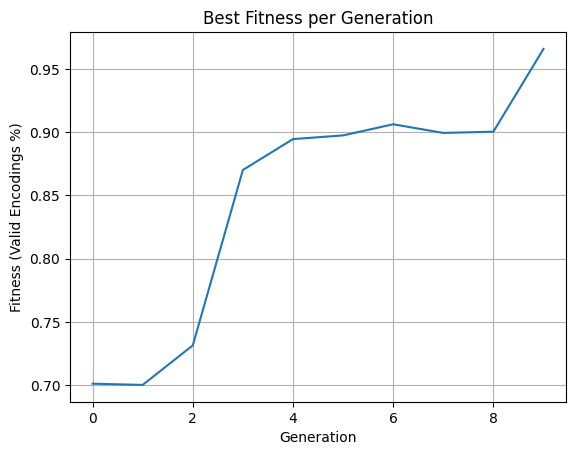

In [9]:
best_params, scores = run_ga()
print("Best Params:", best_params)

plt.plot(scores)
plt.title("Best Fitness per Generation")
plt.xlabel("Generation")
plt.ylabel("Fitness (Valid Encodings %)")
plt.grid()
plt.show()
